In [51]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle # tokenizeri diske kaydetmek için kullanalır

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError 

In [52]:
# load yelp dataset

splits={"train":"yelp_review_full/train-00000-of-00001.parquet"}
train_path="hf://datasets/Yelp/yelp_review_full/" + splits["train"]

In [53]:
# parquet dosyasını pandas dataframe olarak yükle

df=pd.read_parquet(train_path,engine="fastparquet")
# etiketleri 0-4 arasından 0-5 arasına ölçekle
df['label'] = df['label'] + 1
df.head()

,label,text
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...


In [54]:
# data preprocessing
text=df['text'].values
labels=df['label'].values

In [55]:
# tokenizer: metinleri sayısal dizilere dönüştürmek için kullanılır
# num_words: en sık kullanılan kelimelerin sayısı
# OOV: bilinmeyen kelimeler için kullanılacak token
tokenizer=Tokenizer(num_words=10000,oov_token="<OOV>")
tokenizer.fit_on_texts(text)

#tokenizer'i diske kaydet
with open("tokenizer.pkl","wb") as f:
          pickle.dump(tokenizer,f)

In [56]:
# yorumları dizi haline getir

sequences=tokenizer.texts_to_sequences(text)

In [57]:
# tüm dizeleri sabit uzunluğa getir (eksik olanları 0 ile doldur)

padded_sequences=pad_sequences(sequences,maxlen=100,padding='post',truncating='post')

# padding='post'  →  Kısa dizilerin sonuna (sağına) 0 ekler.
# truncating='post'  →  Uzun dizilerin son kısmını (sağdan) keser.

In [58]:
# etiketleri 1-5 aralığından 0-1 aralığına ölçekle

# regression ->  MinMaxScaler , classification -> one-hot encoding

from sklearn.preprocessing import MinMaxScaler


scaler=MinMaxScaler()
labels_scaled=scaler.fit_transform(labels.reshape(-1,1))

In [59]:
# eğitim ve test setlerine ayır

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels_scaled, test_size=0.2, random_state=42)

In [60]:
X_train.shape, y_train.shape, X_train[:2], y_train[:2]

((520000, 100),
 (520000, 1),
 array([[   5,  131,  274,  148,  212,   10,   14,    9,   13,    4,  128,
           86,   41,   12,  959,   46,    8,    2,  108,  271,    5, 1038,
           50,    5,  824,    6, 1408,    5,  617,  363,   38,    8,    2,
          729,    3, 1015,    4,  405,    8,  619,   19,  122,  979,  476,
           11,    2,  128,    3, 1084, 2985,   38,   63,   13,    2,  414,
           11, 5550,   19,  175,  469,    6,  464,   69, 1267,    6,    2,
          128,  174,    5,   24,    4, 1267,    3,   17, 2496,  132,    9,
           38,   10,    4, 3378,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [  30,   13,   51,    5,  214,  144,   96,   10,    2,   54,    3,
            2,  787,  127,  853, 2863, 3575,   73,   19,    4,   63,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    

In [61]:
# lstm modelini oluştur
model=Sequential()

# Embedding: kelime indekslerini vektör uzayına dönüştürür
# input_dim: kelime sayisi
# output_dim:128 -> her bir kelime 128 boyutlu vektör ile temsil edilecek
# input_length: 100 -> her bir girdinin uzunluğu (kelime sayısı)
model.add(Embedding(input_dim=10000,output_dim=128,input_length=100))

# LSTM katmanı : sıralı verilerle bağlamı öğrenecek katman

# 128: lstmde bulunan hücre sayısı yani daha fazla öğrenme kapasitesi
# return_sequences=False: sadece son çıktıyı döndür
model.add(LSTM(128,return_sequences=False))

# Dense (tam bağlı) katman 
model.add(Dense(64,activation='relu'))

# output katmanı

# relu: Hidden layerlar için aktivasyon fonksiyonu (tam bağlı katmanlar)
# tanh: Hidden layerlar için aktivasyon fonksiyonu (LSTM katmanı)
# sigmoid: sınıflandırma için kullanılır (binary classification)
# softmax: sınıflandırma için kullanılır (multi-class classification)
# linear: regresyon için kullanılır
model.add(Dense(1,activation='linear'))

c:\Users\emirh\Desktop\projects\project_3\kcy_nlp\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [62]:
# modeli derle ve eğit

model.compile(

    optimizer='adam', # adaptif öğrenme algoritması
    loss=MeanSquaredError(), # regresyon için kayıp fonksiyonu
    metrics=[MeanAbsoluteError()] # modelin hata ortalaması 
)

history=model.fit(
    X_train,y_train,
    epochs=3,
    batch_size=64, # her adımda işlenecek örnek sayısı
    validation_split=0.2 # eğitim verisinin %20'si doğrulama için ayrılacak
)

Epoch 1/3
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 500s 77ms/step - loss: 0.0560 - mean_absolute_error: 0.1839 - val_loss: 0.0381 - val_mean_absolute_error: 0.1469
Epoch 2/3
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 454s 70ms/step - loss: 0.0362 - mean_absolute_error: 0.1430 - val_loss: 0.0361 - val_mean_absolute_error: 0.1431
Epoch 3/3
6500/6500 ━━━━━━━━━━━━━━━━━━━━ 447s 69ms/step - loss: 0.0320 - mean_absolute_error: 0.1341 - val_loss: 0.0356 - val_mean_absolute_error: 0.1421


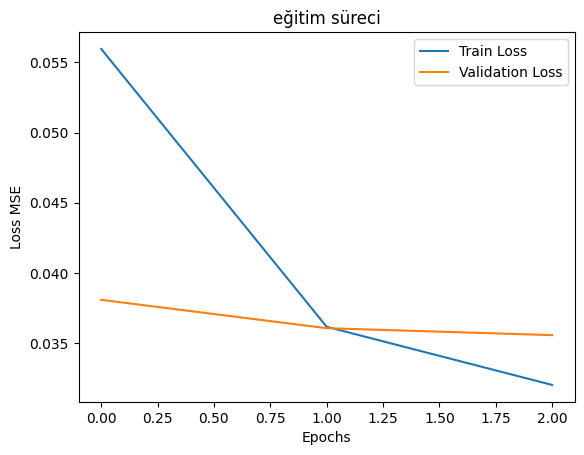

In [63]:
# eğitim kayıp ve doğrulama kaybını çiz

plt.plot(history.history['loss'],label='Train Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.title("eğitim süreci")
plt.xlabel("Epochs")
plt.ylabel("Loss MSE")
plt.legend()
plt.show()


In [64]:
# modeli kaydet
model.save("lstm_regression_yelp_model.h5")